### Load data into data frames

In [1]:
import gzip
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from collections import defaultdict
from itertools import groupby
import seaborn as sns

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)


def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

### Prepare text data for sentimental analysis

E.g.
Given fn.json with rating from 1 to 3,
generate fn_1.txt, fn_2.txt, fn_3.txt

In [27]:
def clean_text(text):
    return text.replace('\n', '')


def extract_review_text(path):
    df = getDF(path)
    dir = path.strip('.json.gz')

    # [1.0, 2.0, 3.0, 4.0, 5.0]
    rating_vals = set(df['overall'].tolist())
    print('Ratings are: {}'.format(rating_vals))

    fps = {r: open('%s_%s.txt'%(dir,str(r)), 'w') for r in rating_vals}
    for r in rating_vals:
      reviews = set(df[df['overall']==r]['reviewText'].values) #TODO: why duplicates?
      print('Extracting reviews for rating {}'.format(r))
      for review in reviews:
        fps[r].write(clean_text(review) + '\n')

    for r in fps:
      fps[r].close()
    
    print('Finish extracting reviews!')

In [28]:
path = 'data/Digital_Music_5.json.gz'
df = getDF(path)

In [29]:
df.shape

(169781, 12)

In [30]:
df[:3]

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5.0,3,True,"06 3, 2013",A2TYZ821XXK2YZ,3426958910,{'Format:': ' Audio CD'},Garrett,"This is awesome to listen to, A must-have for ...",Slayer Rules!,1370217600,NaN
1,5.0,NaN,True,"10 11, 2014",A3OFSREZADFUDY,3426958910,{'Format:': ' Audio CD'},Ad,bien,Five Stars,1412985600,NaN
2,5.0,NaN,True,"02 11, 2014",A2VAMODP8M77NG,3426958910,{'Format:': ' Audio CD'},JTGabq,It was great to hear the old stuff again and I...,SLAYER!!!!!!!!!!!!!!!!!!!!!,1392076800,NaN


At the moment, we aren't using **'image'** and **'style'**

In [31]:
df = df.drop('image', 1)
df['vote'].fillna(0, inplace=True)

In [32]:
uniDf = df.drop('style', 1).drop_duplicates()
uniDf.shape

(146149, 10)

In [33]:
uniDf.drop_duplicates(subset=['reviewerID', 'asin']).shape

(145292, 10)

In [34]:
uniDf

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime
0,5.0,3,True,"06 3, 2013",A2TYZ821XXK2YZ,3426958910,Garrett,"This is awesome to listen to, A must-have for ...",Slayer Rules!,1370217600
1,5.0,0,True,"10 11, 2014",A3OFSREZADFUDY,3426958910,Ad,bien,Five Stars,1412985600
2,5.0,0,True,"02 11, 2014",A2VAMODP8M77NG,3426958910,JTGabq,It was great to hear the old stuff again and I...,SLAYER!!!!!!!!!!!!!!!!!!!!!,1392076800
3,4.0,3,False,"12 7, 2013",AAKSLZ9IDTEH0,3426958910,john F&#039;n doe,well best of's are a bit poison normally but t...,slayer greatest hits! you mean everything righ...,1386374400
4,5.0,0,True,"06 12, 2016",A3OH43OZJLKI09,5557706259,melinda a goodman,What can I say? This is Casting Crowns!!!This ...,"This is a good, blessing filled",1465689600
...,...,...,...,...,...,...,...,...,...,...
169776,5.0,0,True,"08 19, 2018",A1SR2T84IXOMAQ,B01HJ91MTW,Diane B.,Casting Crowns songs are all wonderful!!,Great song!!,1534636800
169777,5.0,0,True,"03 18, 2018",A2SR3DWJR1PYR6,B01HJ91MTW,jan c.,Just reminds you that you are never alone.,Five Stars,1521331200
169778,5.0,0,True,"03 7, 2018",A24V7X30NIMOIY,B01HJ91MTW,Lori Y,"Good product, good service.",Five Stars,1520380800
169779,5.0,0,True,"02 12, 2018",A1LW10GYP2EYM1,B01HJ91MTW,N F,I love every single song this group sings. The...,Absolutely beautiful...,1518393600


In [51]:
uniDf['vote'] = uniDf['vote'].apply(lambda v : str(v).replace(',', ''))
uniDf['vote'] = pd.to_numeric(uniDf['vote'])
uniDf['reviewText'].fillna('', inplace=True)

In [57]:
ratings = list(uniDf['overall'])
votes = list(uniDf['vote'])
items = list(uniDf['asin'])
verified = list(uniDf['verified'])
reviews = list(uniDf['reviewText'])

count_r = [0] * 6
count_verified = [0] * 6
count_non_verified = [0] * 6
r_items = defaultdict(list)
count_r_items = [0] * 6
count_review_length = [0] * 7

In [58]:
uniDf.reset_index(drop=True)

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime
0,5.0,3,True,"06 3, 2013",A2TYZ821XXK2YZ,3426958910,Garrett,"This is awesome to listen to, A must-have for ...",Slayer Rules!,1370217600
1,5.0,0,True,"10 11, 2014",A3OFSREZADFUDY,3426958910,Ad,bien,Five Stars,1412985600
2,5.0,0,True,"02 11, 2014",A2VAMODP8M77NG,3426958910,JTGabq,It was great to hear the old stuff again and I...,SLAYER!!!!!!!!!!!!!!!!!!!!!,1392076800
3,4.0,3,False,"12 7, 2013",AAKSLZ9IDTEH0,3426958910,john F&#039;n doe,well best of's are a bit poison normally but t...,slayer greatest hits! you mean everything righ...,1386374400
4,5.0,0,True,"06 12, 2016",A3OH43OZJLKI09,5557706259,melinda a goodman,What can I say? This is Casting Crowns!!!This ...,"This is a good, blessing filled",1465689600
...,...,...,...,...,...,...,...,...,...,...
146144,5.0,0,True,"08 19, 2018",A1SR2T84IXOMAQ,B01HJ91MTW,Diane B.,Casting Crowns songs are all wonderful!!,Great song!!,1534636800
146145,5.0,0,True,"03 18, 2018",A2SR3DWJR1PYR6,B01HJ91MTW,jan c.,Just reminds you that you are never alone.,Five Stars,1521331200
146146,5.0,0,True,"03 7, 2018",A24V7X30NIMOIY,B01HJ91MTW,Lori Y,"Good product, good service.",Five Stars,1520380800
146147,5.0,0,True,"02 12, 2018",A1LW10GYP2EYM1,B01HJ91MTW,N F,I love every single song this group sings. The...,Absolutely beautiful...,1518393600


In [59]:
item_rating = []
for i in range(len(ratings)):
    r_items[items[i]].append(ratings[i])
for item in r_items:
    counts = np.bincount(r_items[item])
    count = np.argmax(counts)
    count_r_items[count] += 1
count_r_items = count_r_items[1:]

In [60]:
zero_votes = []
non_zero_votes = []
verified_rating = []
non_verified_rating = []
review_length = []

for i in range(len(ratings)):
    if verified[i] == True:
        count_verified[int(ratings[i])] += 1
        verified_rating.append(ratings[i])
    else :
        count_non_verified[int(ratings[i])] += 1
        non_verified_rating.append(ratings[i])
    count_r[int(ratings[i])] += 1
    review_length.append(len(str(reviews[i])))

In [61]:
max_len = 0
for review in reviews:
    if type(review) == float:
        print(review)
    if len(review) > max_len:
        max_len = len(review)
max_len = max_len//7

In [62]:
i = 0
for k, g in groupby(sorted(review_length), key=lambda x: x//max_len):
    count_review_length[i] = len(list(g))
    i += 1
print(count_review_length)

[145715, 372, 47, 5, 6, 3, 1]


In [63]:
print(count_r)
print(count_verified)
print(count_non_verified)
#print(review_length)

[0, 1899, 1658, 6078, 20084, 116430]
[0, 1166, 958, 4851, 17114, 104557]
[0, 733, 700, 1227, 2970, 11873]


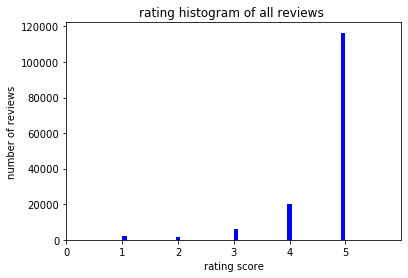

In [64]:
n,bins,patches = plt.hist(ratings,50, facecolor='blue')
plt.xlim([0,6])
plt.xlabel("rating score")
plt.ylabel("number of reviews")
plt.title("rating histogram of all reviews ")
plt.xticks(np.arange(0,6,1))
plt.savefig('rating_histogram')
plt.show()

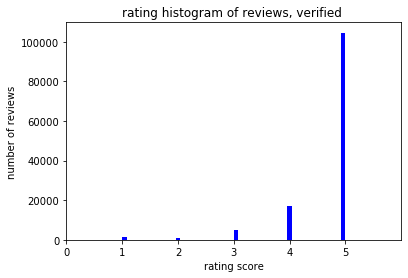

In [65]:
n,bins,patches = plt.hist(verified_rating,50, facecolor='blue')
plt.xlim([0,6])
plt.xlabel("rating score")
plt.ylabel("number of reviews")
plt.title("rating histogram of reviews, verified ")
plt.xticks(np.arange(0,6,1))
plt.savefig('verified_rating_histogram')
plt.show()

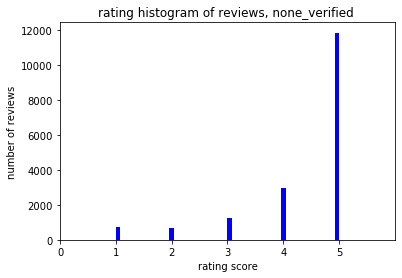

In [66]:
n,bins,patches = plt.hist(non_verified_rating,50, facecolor='blue')
plt.xlim([0,6])
plt.xlabel("rating score")
plt.ylabel("number of reviews")
plt.title("rating histogram of reviews, none_verified ")
plt.xticks(np.arange(0,6,1))
plt.savefig('none_verified rating_histogram')
plt.show()

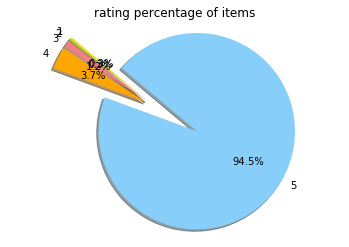

In [67]:
labels = ['1', '2', '3','4','5']
colors = ['gold', 'yellowgreen', 'lightcoral', 'orange','lightskyblue']
explode = (0.1, 0.1, 0.1, 0.1, 0.5)  # explode 1st slice


plt.pie(count_r_items, labels=labels,explode = explode, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title("rating percentage of items")
plt.show()

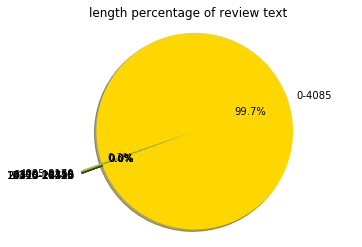

In [68]:
labels = ['0-'+str(max_len), str(max_len)+'-'+str(max_len*2), str(max_len*2)+'-'+str(max_len*3),str(max_len*3)+'-'+str(max_len*4),str(max_len*4)+'-'+str(max_len*5), str(max_len*5)+'-'+str(max_len*6), str(max_len*6)+'-'+str(max_len*7)]
colors = ['gold', 'yellowgreen', 'lightcoral', 'orange','lightskyblue']
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)  # explode 1st slice


plt.pie(count_review_length, labels=labels,explode = explode, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=200)
plt.axis('equal')
plt.title("length percentage of review text")
plt.show()

### Vote distribution versus rating

In [65]:
uniDf.dtypes

overall           float64
verified             bool
reviewTime         object
reviewerID         object
asin               object
reviewerName       object
reviewText         object
summary            object
unixReviewTime      int64
vote                int64
dtype: object

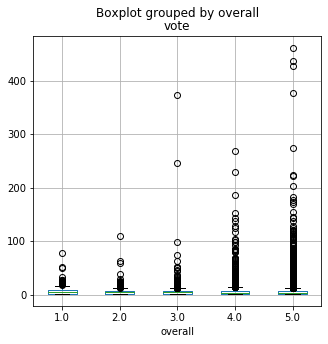

In [69]:
fig, ax = plt.subplots(figsize=(5,5))
plt.suptitle('')
uniDf[uniDf['vote'] != 0].boxplot(column=['vote'], by='overall', ax=ax)

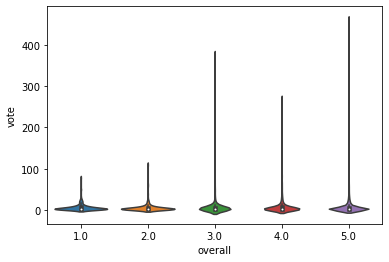

In [71]:
sns.violinplot(data=uniDf[uniDf['vote'] != 0], x='overall', y='vote')

### Extract and save each review and its rating

In [72]:
uniDf.to_csv(path.strip('.json.gz') + '.csv', columns = ['reviewerID', 'asin', 'overall'], index=False)

### Get a list of styles and save to JSON

In [73]:
styles = defaultdict(set)
for style in df['style'].values:
    if type(style) != dict:
        continue
    for key in style:
        styles[key.replace(':', '')].add(style[key])

In [74]:
with open(path.strip('.json.gz')+'_styles.json', 'w') as fp:
    data = {key:list(styles[key]) for key in styles}
    json.dump(data, fp, sort_keys=True, indent=4)

### Temporal Effects

Trend of number of reviews and average ratings over months

In [75]:
minMonth = uniDf['unixReviewTime'].min()//(30*24*60*60)

def unixTimeToMonth(row):
    return row['unixReviewTime']//(30*24*60*60) - minMonth

uniDf['normalizedMonth'] = uniDf.apply(unixTimeToMonth, axis=1)

print('Range of normalized months: {0} - {1}'.format(uniDf['normalizedMonth'].min(), uniDf['normalizedMonth'].max()))

Range of normalized months: 0 - 246


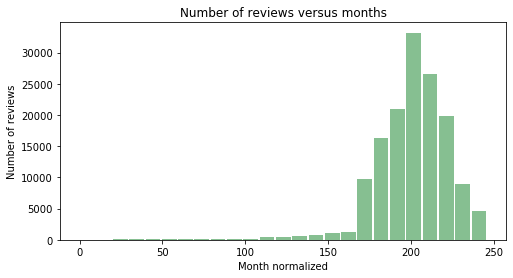

In [76]:
ax = uniDf.hist('normalizedMonth', bins=25, grid=False, figsize=(8,4), color='#86bf91', zorder=2, rwidth=0.9)
for x in ax[0]:
    x.set_title('Number of reviews versus months')
    x.set_xlabel('Month normalized')
    x.set_ylabel('Number of reviews')

Text(0.5, 1.0, 'Average rating versus months')

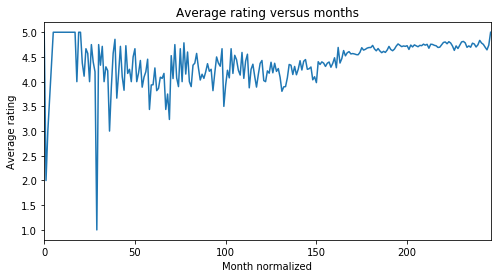

In [77]:
avgRatings = uniDf.groupby('normalizedMonth').mean()['overall']
ax = avgRatings.plot(figsize=(8,4))
ax.set_ylabel('Average rating')
ax.set_xlabel('Month normalized')
ax.set_title('Average rating versus months')